In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import statsmodels.formula.api as sf
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
path = os.path.join("data", "caseStudyCleaned.csv")
df = pd.read_csv(path)
print(df.head())
df.shape

   ID  CustomerAgeinmonths  Churn1Yes0No  CHIScoreMonth0  CHIScore01  \
0   1                 67.0           0.0             0.0         0.0   
1   2                 67.0           0.0            62.0         4.0   
2   3                 55.0           0.0             0.0         0.0   
3   4                 63.0           0.0           231.0         1.0   
4   5                 57.0           0.0            43.0         1.0   

   SupportCasesMonth0  SupportCases01  SPMonth0  SP01  Logins01  \
0                 0.0             0.0       0.0   0.0       0.0   
1                 0.0             0.0       0.0   0.0       0.0   
2                 0.0             0.0       0.0   0.0       0.0   
3                 1.0             1.0       3.0   0.0     167.0   
4                 0.0             0.0       0.0   0.0       0.0   

   BlogArticles01  Views01  DaysSinceLastLogin01  
0             0.0      0.0                  31.0  
1             0.0     16.0                  31.0  
2          

(6347, 13)

1. Is Wall’s belief about the dependence of churn rates on customer age supported by the data? To get some intuition, try visualizing this dependence (Hint: no need to run any statistical tests).

(6024, 13)
(323, 13)


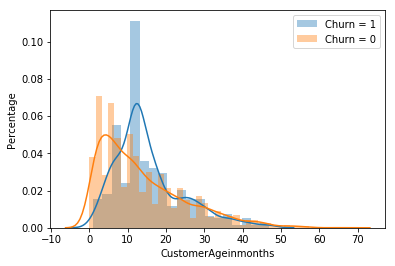

In [3]:
newDf = df.loc[df["Churn1Yes0No"] == 0]
print(newDf.shape)
newDf = df.loc[df["Churn1Yes0No"] == 1]
print(newDf.shape)
dp = sns.distplot((df.loc[df["Churn1Yes0No"] == 1])["CustomerAgeinmonths"], label="Churn = 1")
dp = sns.distplot((df.loc[df["Churn1Yes0No"] == 0])["CustomerAgeinmonths"], label="Churn = 0")
dp.set(xlabel='CustomerAgeinmonths', ylabel='Percentage')
dp.legend()

The dependence of churn rates on customer age is not supported from the plot. 
From the observation above, we can clearly see that the 2 histograms overlap a lot, especially at the right tail part.

2. To start, run a single regression model that best predicts the probability that a customer leaves.

In [45]:
def findBest(df):
    y = np.array([df["Churn1Yes0No"]]).T
    col = df.columns
    col = col.drop(["Churn1Yes0No", "ID"])
    loss = []
    models = []
    results = []
    scores = []
    for c in col:
        x = np.array([df[c]]).T
        x = x.reshape(-1, 1)
        lr = LogisticRegression(solver = 'lbfgs').fit(x, y)
        models.append(lr)
        result = lr.predict_proba(x)
        s = lr.score(x, y)
        scores.append(s)
        results.append(result)
        e = metrics.log_loss(y, result)
        loss.append(e)
    minLoss = min(loss)
    index = loss.index(minLoss)
    print("min loss column: " + col[index])
    print("min loss: " + str(loss[index]))
    print("score: " + str(scores[index]))
    return models[index], results[index]
    
bestLr, bestProb = findBest(df)

min loss column: CHIScoreMonth0
min loss: 0.19746231419598212
score: 0.9491098156609422


We are using the minimum loss of the model to decide which one is the "best prediction", because low loss means low error of our predictions. The function findBest will find the minimum loss variable given a data frame, and return the best model and the predicted probabilities.
We can see CHIScoreMonth0 is the best predictor.

    a. What is the predicted probability that Customer 672 will leave between December 2011 and February 2012? Is that high or low? Did that customer actually leave?

In [30]:
def testChurn(id, result):
    id -= 1
    cus = df.iloc[id][:]
    print(result[id][1])
    print(cus["Churn1Yes0No"])

testChurn(672, bestProb)

0.03320296775110835
0.0


Probability is 0.033. It's small, and the customer didn't not actually leave.

    b. What about Customers 354 and 5,203?

In [32]:
testChurn(354, bestProb)

0.03502742009007797
0.0


In [31]:
testChurn(5203, bestProb)

0.06366613937623121
0.0


3. How sensible is the approach with a single model? Can you suggest a better approach?

0.013461575208371343
0.07866375501421338


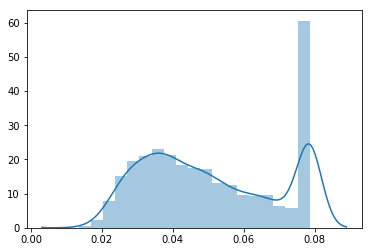

In [50]:
sns.distplot(bestProb[:, 1])
print(min(bestProb[:, 1]))
print(max(bestProb[:, 1]))

It's not sensible. We print the minimum and the maximum of all predictions. We can tell that all the predictions are not churn, which is not a prediction.
A better approach should be multiple logistic regression.

    a. Provide updated estimates of probabilities that Customers 672, 354, and 5,203 will leave.

In [39]:
import itertools

columns = df.columns

x_columns = columns.drop(["ID", "Churn1Yes0No"])
allSubset = []
for i in range(len(x_columns)):
    s = set(itertools.combinations(x_columns, i + 1))
    for subS in s:
        allSubset.append(subS)
    
def bestInAll(df, allSets):
    y = df["Churn1Yes0No"]
    loss = []
    subSets = []
    for s in allSets:
        x = df[list(s)]
        lr = LogisticRegression(solver = 'lbfgs').fit(x, y)
        result = lr.predict_proba(x)
        e = metrics.log_loss(y, result)
        loss.append(e) 
        subSets.append(s)
    minLoss = min(loss)
    index = loss.index(minLoss)
    print(minLoss)
    print(subSets[index])

# bestInAll(df, allSubset)

0.1936794274987956
('CustomerAgeinmonths', 'CHIScoreMonth0', 'CHIScore01', 'SupportCasesMonth0', 'SupportCases01', 'SPMonth0', 'SP01', 'BlogArticles01', 'DaysSinceLastLogin01')


In [41]:
columns = ['CustomerAgeinmonths', 'CHIScoreMonth0', 'CHIScore01', 'SupportCasesMonth0', 'SupportCases01', 'SPMonth0', 'SP01', 'BlogArticles01', 'DaysSinceLastLogin01']
x = df[columns]
y = df["Churn1Yes0No"]
improvedLr = LogisticRegression(solver = 'lbfgs').fit(x, y)

In [47]:
probs = improvedLr.predict_proba(x)
testChurn(672, probs)
testChurn(354, probs)
testChurn(5203, probs)

0.030951367341322665
0.0
0.03382167997558077
0.0
0.05348742330420229
0.0


0.0013144614802430177
0.9788646749561799


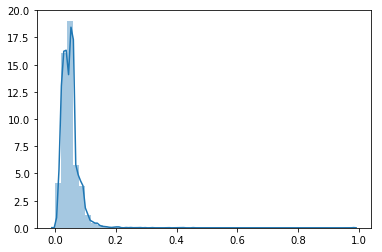

In [51]:
sns.distplot(probs[:, 1])
print(min(probs[:, 1]))
print(max(probs[:, 1]))

    b. What factors contribute the most to the predicted probabilities that these customers will leave?

In [67]:
l = np.std(x, 0) * improvedLr.coef_[0]
print(l)

CustomerAgeinmonths     0.172276
CHIScoreMonth0         -0.400274
CHIScore01              0.082664
SupportCasesMonth0      0.047424
SupportCases01         -0.149964
SPMonth0               -0.135071
SP01                    0.117251
BlogArticles01         -0.041664
DaysSinceLastLogin01    0.180944
dtype: float64


4. Answer Wall’s “ultimate question”: provide the list of 100 customers with highest churn
probabilities and the top three drivers of churn for each customer.

In [69]:
datas = []
for i in range(len(probs)):
    datas.append([i, probs[i][0]])
    
def getProb(d):
    return d[1]

datas.sort(key=getProb)
for i in range(100):
    print(datas[i][0])

2699
1495
132
1862
2562
1889
870
1521
1180
1107
93
51
2280
191
2943
109
1029
3087
48
165
193
3256
59
3026
0
3580
535
2010
1802
2078
1770
2095
13
1009
2
17
20
1218
2747
3582
1062
269
3786
108
1335
50
3292
1198
2946
2615
54
58
3685
60
61
120
94
1362
1801
68
136
1
11
1005
1315
153
2834
122
169
118
170
189
862
145
182
41
100
2991
4
88
75
2829
2650
1458
1392
3332
1391
2239
1437
155
67
1970
1671
1140
105
2243
15
3694
1276
2300
